# Multi-agent supervisor

The [previous example](../multi-agent-collaboration) routed messages automatically based on the output of the initial researcher agent.

We can also choose to use an [LLM to orchestrate](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#supervisor) the different agents.

Below, we will create an agent group, with an agent supervisor to help delegate tasks.

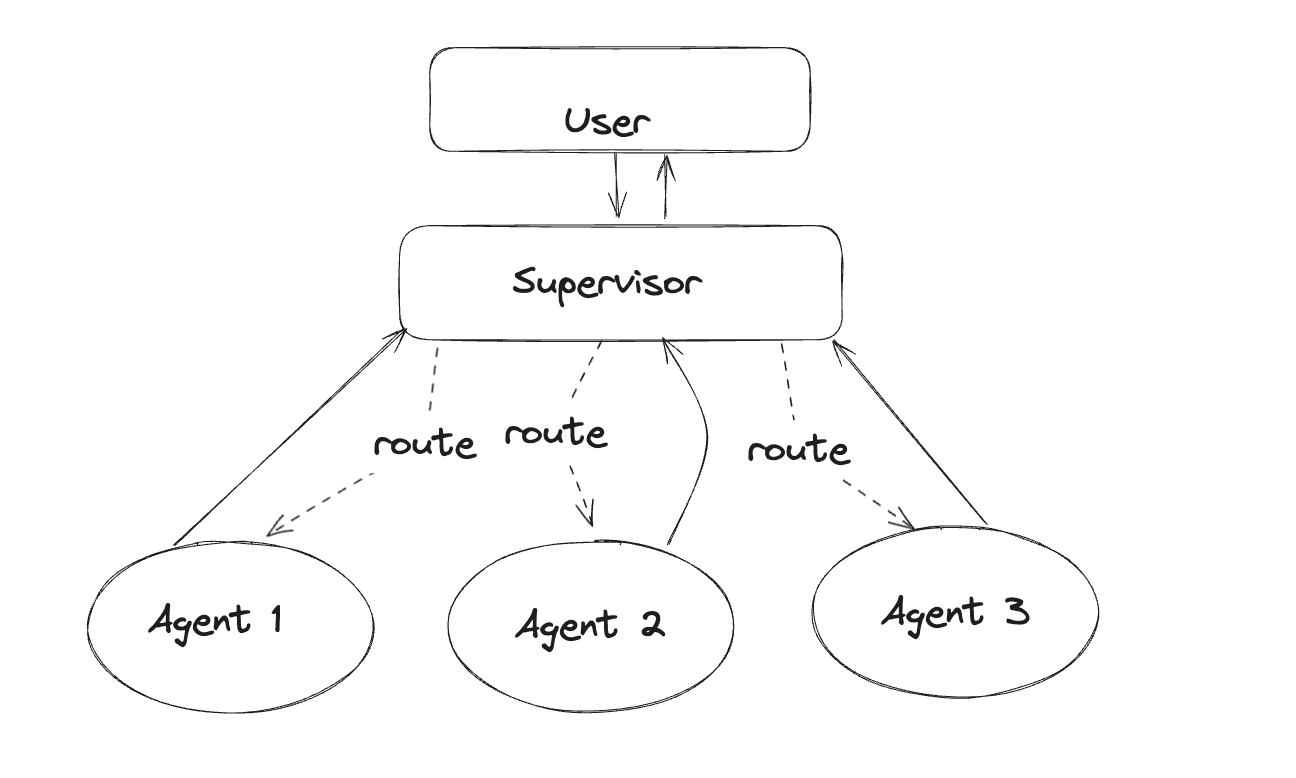

To simplify the code in each agent node, we will use LangGraph's prebuilt [create_react_agent](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.chat_agent_executor.create_react_agent). This and other "advanced agent" notebooks are designed to show how you can implement certain design patterns in LangGraph. If the pattern suits your needs, we recommend combining it with some of the other fundamental patterns described elsewhere in the docs for best performance.

## Setup

First, let's install required packages and set our API keys

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain_community langchain_anthropic langchain_experimental

In [2]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("ANTHROPIC_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

KeyboardInterrupt: Interrupted by user

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>

## Create tools

For this example, you will make an agent to do web research with a search engine, and one agent to create plots. Define the tools they'll use below:

In [21]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

from langchain_community.tools.ddg_search.tool import DuckDuckGoSearchResults  
tavily_tool = DuckDuckGoSearchResults(max_results=4, output_format="list")

# This executes code locally, which can be unsafe
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return result_str

### Create Agent Supervisor

It will use LLM with structured output to choose the next worker node OR finish processing.

In [22]:
from typing import Literal
from typing_extensions import TypedDict

from langchain_anthropic import ChatAnthropic
from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["researcher", "coder"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


llm = ChatAnthropic(model="claude-3-5-sonnet-latest")


class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

## Construct Graph

We're ready to start building the graph. Below, define the state and worker nodes using the function we just defined.

In [23]:
!pip install langchain
!pip install langgraph

In [37]:
from typing import Annotated, Literal, TypedDict
from langchain_community.tools.ddg_search.tool import DuckDuckGoSearchResults
from langchain_experimental.utilities import PythonREPL
from langchain_core.tools import tool
from langchain_anthropic import ChatAnthropic
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langchain.prompts import PromptTemplate
from langchain.agents import create_react_agent
from langchain_core.messages import AIMessage

# Initialize tools
tavily_tool = DuckDuckGoSearchResults(max_results=4, output_format="list")
repl = PythonREPL()

# Define Python REPL tool
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

# Team setup
members = ["researcher", "coder"]
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

class State(TypedDict):
    messages: list
    next: str

# Initialize LLM
llm = ChatAnthropic(model="claude-3-sonnet-20240229")

# Supervisor node
def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    response = llm.invoke(messages)
    next_step = response.content.strip()
    return {"next": next_step}  # Update state with next step

# Researcher agent
research_prompt = PromptTemplate.from_template(
    """You are a researcher. DO NOT do any math.
    Tools: {tools}
    Tool Names: {tool_names}
    Question: {input}
    Thought: {agent_scratchpad}"""
)
research_agent = create_react_agent(llm, tools=[tavily_tool], prompt=research_prompt)

def research_node(state: State):
    result = research_agent.invoke({"input": state["messages"][-1]["content"]})
    return {
        "messages": state["messages"] + [AIMessage(content=result["output"], name="researcher")],
        "next": "supervisor"
    }

# Coder agent
coder_prompt = PromptTemplate.from_template(
    """You are a coder. Use the python_repl_tool to execute code.
    Tools: {tools}
    Tool Names: {tool_names}
    Question: {input}
    Thought: {agent_scratchpad}"""
)
coder_agent = create_react_agent(llm, tools=[python_repl_tool], prompt=coder_prompt)

def coder_node(state: State):
    result = coder_agent.invoke({"input": state["messages"][-1]["content"]})
    return {
        "messages": state["messages"] + [AIMessage(content=result["output"], name="coder")],
        "next": "supervisor"
    }

# Build the graph
builder = StateGraph(State)
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", coder_node)

# Add edges
builder.add_edge(START, "supervisor")
builder.add_edge("researcher", "supervisor")
builder.add_edge("coder", "supervisor")

# Add single conditional edge for supervisor
def route_to_next(state: State):
    if "next" not in state:
        return "supervisor"
    if state["next"] == "FINISH":
        return END
    return state["next"]

builder.add_conditional_edges(
    "supervisor",
    route_to_next,
    {
        "researcher": "researcher",
        "coder": "coder",
        "supervisor": "supervisor",
        "FINISH": END
    }
)

graph = builder.compile()

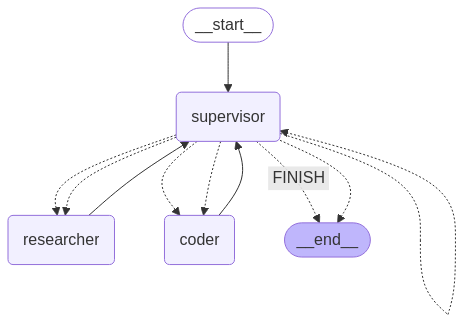

In [38]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

## Invoke the team

With the graph created, we can now invoke it and see how it performs!

In [12]:
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "Find the latest GDP of New York and California, then calculate the average",
            )
        ]
    },
    subgraphs=True,
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:7daea379-a5b6-6d3d-ef85-fffc96d7472e',), {'agent': {'messages': [AIMessage(content=[{'text': "I'll help you search for the GDP data of New York and California using the search tool. Then I'll note the values, but as instructed, I won't perform the mathematical calculation myself.", 'type': 'text'}, {'id': 'toolu_01S9hPD5nFsW1A2nE4fwCvRc', 'input': {'query': 'latest GDP of New York state 2023'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01RetKetMGpP2Q51w4R8N81e', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 442, 'output_tokens': 107}}, id='run-6e738192-18ae-4c1a-bbc0-f8b8509fe656-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'latest GDP of New York state 2023'}, 'id': 'toolu_01S9hPD5nFsW1A2nE4fwCvRc', 'type': 'tool_call'}], usage_metadata={'input_tokens': 442,